In [10]:
import numpy as np
import networkx as nx
from utils.dotdict import dotdict
import matplotlib.pyplot as plt
%matplotlib inline

#from utils.plot_gergo import *
from utils.graph_generator import get_graph

from scripts.awareness.agent_country import Agent_Country

%reload_ext autoreload
%autoreload 2


In [11]:
def run_one_seed(betas,gammas,ns,max_infs,name):
    results = []
    iterations=100

    for beta_i, beta in enumerate(betas):
        for n_i, n in enumerate(ns):
            for max_inf_i, max_inf in enumerate(max_infs):
                results.append([])
                for it in range(iterations):
                    temp_results =[]
                    graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
                    args = dotdict({
                        "logfile": "data_awareness/example2" +name +"_"+str(beta)+"_"+ str(gammas[beta_i])+ "_" +str(n)+"_"+ str(max_inf)+ "_" +str(it) +".csv",
                        "plot": False,
                        "max_iteration": 1000,
                        "beta": beta,
                        "beta_super":0.0,
                        "sigma": 0.5,
                        "gamma": gammas[beta_i],
                        "xi": 1,
                        "p_teleport":0.0,
                        "MAX_E_TIME":10,
                        "MAX_I_TIME":10,
                        "infected_agents": [n//2+(n//2)*n],
                        "super_infected_agents": [],
                        "p_super": 0.0,
                        "awM": max_inf,
                        "awR": -1,
                        "random_seed":0
                    })
                    args["I_time"]=int(1/args["gamma"])

                    country = Agent_Country(args, graph)
                    Agent_Country.numba_random_seed(it)
                    for i in range(args["max_iteration"]):
                        temp_results.append(np.sum(country.states==2))
                        if country.check_stop():
                            #break
                            pass
                        country.step()
                    results[-1].append(np.mean(temp_results[len(temp_results)//2:]))
    return results

In [12]:
#run_one_seed([0.5],[0.25],[10], [0.1],"gb_const")

## 1. Deriving the formula for the expected number of infected nodes in the stable regime (one seed):
We are going to guess the formula
\begin{align}
c_g \beta (1-\mathrm{m})^I &= \gamma \\
I \log(1-\mathrm{m}) &= \log\left(\frac{\gamma}{\beta c_g}\right) \\
I &= \frac{\log\left(\frac{\gamma}{\beta c_g}\right)}{\log(1-m)} = \frac{\log\left(c_g\frac{\beta}{\gamma}\right)}{\log\left(\frac{1}{1-m}\right)}
\end{align}

Now we test it empirically.

## Grid graphs

In [13]:
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
results_gb_const_grid = run_one_seed(betas,betas/2,[10], [0.1],"gb_const")

In [14]:
results_gb_const_grid;

In [15]:
results_gb_change_grid = run_one_seed(betas,betas/np.array(gb),[10], [0.1] ,"gb_change")

In [16]:
results_n_grid = run_one_seed([0.6],[0.3],[10,15,20,25], [0.1] ,"n")

In [17]:
results_max_inf_grid = run_one_seed([0.6],[0.3],[10], list(map(lambda x: 1-np.exp(-1/x), range(1,10))) ,"max_inf")

/home/doma945/p36/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


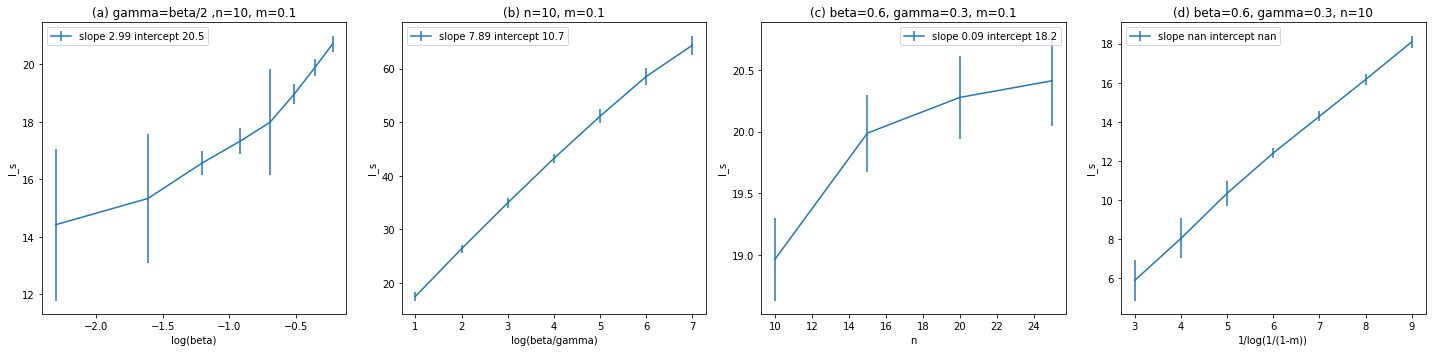

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
mean_results_gb_const_grid=list(map(np.mean,results_gb_const_grid))
std_results_gb_const_grid=list(map(np.std,results_gb_const_grid))
plt.errorbar(np.log(betas[:-1]),mean_results_gb_const_grid[:-1],yerr=std_results_gb_const_grid[:-1])
plt.ylabel("I_s")
plt.xlabel("log(beta)")
plt.title("(a) gamma=beta/2 ,n=10, m=0.1")
sl, inter = np.polyfit(np.log(betas[:-1]),mean_results_gb_const_grid[:-1], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(1,4,2)
mean_results_gb_change_grid=list(map(np.mean,results_gb_change_grid))
std_results_gb_change_grid=list(map(np.std,results_gb_change_grid))
#plt.errorbar(range(1,8),mean_results_gb_change_grid[:-2], yerr= std_results_gb_change_grid[:-2])
plt.errorbar(np.log(gb)[:-2],mean_results_gb_change_grid[:-2], yerr= std_results_gb_change_grid[:-2])
plt.title("(b) n=10, m=0.1")
plt.ylabel("I_s")
plt.xlabel("log(beta/gamma)")
sl, inter = np.polyfit(range(1,8),mean_results_gb_change_grid[:-2], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(1,4,3)
mean_results_n_grid=list(map(np.mean,results_n_grid))
std_results_n_grid=list(map(np.std,results_n_grid))
plt.errorbar([10,15,20,25],mean_results_n_grid,yerr=std_results_n_grid)
plt.title("(c) beta=0.6, gamma=0.3, m=0.1")
plt.ylabel("I_s")
plt.xlabel("n")
sl, inter = np.polyfit([10,15,20,25],mean_results_n_grid, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(1,4,4)
temp_results_max_inf_grid=results_max_inf_grid
temp_results_max_inf_grid=list(map(lambda y: list(filter(lambda x: x>3, y)) ,temp_results_max_inf_grid))[1:]
mean_results_max_inf_grid=list(map(np.mean,temp_results_max_inf_grid))
std_results_max_inf_grid=list(map(np.std,temp_results_max_inf_grid))
plt.errorbar(range(2,10),mean_results_max_inf_grid,yerr=std_results_max_inf_grid)
plt.title("(d) beta=0.6, gamma=0.3, n=10")
plt.ylabel("I_s")
plt.xlabel("1/log(1/(1-m))")
sl, inter = np.polyfit(range(2,10),mean_results_max_inf_grid, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])
plt.tight_layout()
plt.savefig("log/grid10.pdf")

From the slope of plot (b) we should have
$$\frac{1}{\log\left(\frac{1}{1-m}\right)} \approx 8.52$$

In [8]:
1/np.log(1/(1-0.1))

9.4912215810299

From the slope of plot (d) we should have
$$\log\left(c_g \frac{\beta}{\gamma}\right) \approx 1.49 \Rightarrow c_g \approx \frac{e^{1.49}}{2}\approx 2.2$$


In [9]:
np.exp(1.49)/2

2.218547759501832

From the intercept of plot (d) we should have
$$\frac{\log\left(c_g\right)}{\log\left(\frac{1}{1-m}\right)} \approx 7.42$$

In [19]:
np.log(np.exp(1.49)/2)/np.log(1/(1-0.1))

7.563106676773967

### Larger size

In [11]:
results_gb_change_grid30 = run_one_seed(betas,betas/np.array(gb),[50], [0.1] ,"gb_change")

In [12]:
results_max_inf_grid30 = run_one_seed([0.6],[0.3],[100], list(map(lambda x: 1-np.exp(-1/x), range(1,10))) ,"max_inf")

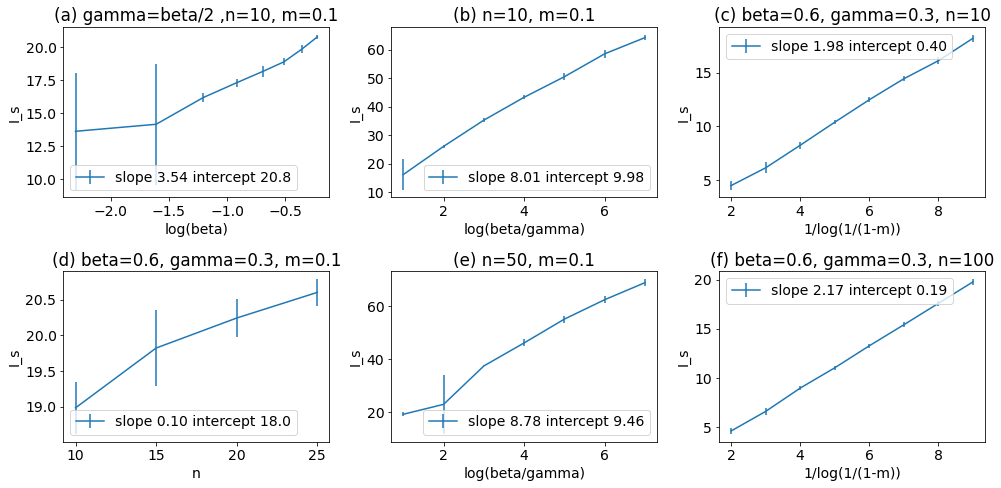

In [13]:
plt.rcParams.update({'font.size': 14})
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 

plt.figure(figsize=(14,7))
plt.subplot(2,3,1)
mean_results_gb_const_grid=list(map(np.mean,results_gb_const_grid))
std_results_gb_const_grid=list(map(np.std,results_gb_const_grid))
plt.errorbar(np.log(betas[:-1]),mean_results_gb_const_grid[:-1],yerr=std_results_gb_const_grid[:-1])
plt.ylabel("I_s")
plt.xlabel("log(beta)")
plt.title("(a) gamma=beta/2 ,n=10, m=0.1")
sl, inter = np.polyfit(np.log(betas[:-1]),mean_results_gb_const_grid[:-1], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,2)
mean_results_gb_change_grid=list(map(np.mean,results_gb_change_grid))
std_results_gb_change_grid=list(map(np.std,results_gb_change_grid))
plt.errorbar(range(1,8),mean_results_gb_change_grid[:-2], yerr= std_results_gb_change_grid[:-2])
plt.title("(b) n=10, m=0.1")
plt.ylabel("I_s")
plt.xlabel("log(beta/gamma)")
sl, inter = np.polyfit(range(1,8),mean_results_gb_change_grid[:-2], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,3)
temp_results_max_inf_grid=results_max_inf_grid
temp_results_max_inf_grid=list(map(lambda y: list(filter(lambda x: x>3, y)) ,temp_results_max_inf_grid))[1:]
mean_results_max_inf_grid=list(map(np.mean,temp_results_max_inf_grid))
std_results_max_inf_grid=list(map(np.std,temp_results_max_inf_grid))
plt.errorbar(range(2,10),mean_results_max_inf_grid,yerr=std_results_max_inf_grid)
plt.title("(c) beta=0.6, gamma=0.3, n=10")
plt.ylabel("I_s")
plt.xlabel("1/log(1/(1-m))")
sl, inter = np.polyfit(range(2,10),mean_results_max_inf_grid, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,4)
mean_results_n_grid=list(map(np.mean,results_n_grid))
std_results_n_grid=list(map(np.std,results_n_grid))
plt.errorbar([10,15,20,25],mean_results_n_grid,yerr=std_results_n_grid)
plt.title("(d) beta=0.6, gamma=0.3, m=0.1")
plt.ylabel("I_s")
plt.xlabel("n")
sl, inter = np.polyfit([10,15,20,25],mean_results_n_grid, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,5)
mean_results_gb_change_grid30=list(map(np.mean,results_gb_change_grid30))
std_results_gb_change_grid30=list(map(np.std,results_gb_change_grid30))
plt.errorbar(range(1,8),mean_results_gb_change_grid30[:-2], yerr= std_results_gb_change_grid30[:-2])
plt.title("(e) n=50, m=0.1")
plt.ylabel("I_s")
plt.xlabel("log(beta/gamma)")
sl, inter = np.polyfit(range(1,8),mean_results_gb_change_grid30[:-2], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,6)

temp_results_max_inf_grid=results_max_inf_grid30
temp_results_max_inf_grid=list(map(lambda y: list(filter(lambda x: x>2*np.sqrt(np.mean(y)), y)) ,temp_results_max_inf_grid))[1:]
mean_results_max_inf_grid=list(map(np.mean,temp_results_max_inf_grid))
std_results_max_inf_grid=list(map(np.std,temp_results_max_inf_grid))
plt.errorbar(range(2,10),mean_results_max_inf_grid,yerr=std_results_max_inf_grid)
plt.title("(f) beta=0.6, gamma=0.3, n=100")
plt.ylabel("I_s")
plt.xlabel("1/log(1/(1-m))")
sl, inter = np.polyfit(range(2,10),mean_results_max_inf_grid, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.tight_layout()
plt.savefig("log/grid.pdf")


In [14]:
np.exp(1.80)/2

3.0248237322064733

## Random regular graphs (d=4)

In [15]:
def run_one_seed_rrg(betas,gammas,ns,max_infs,name):
    results = []
    iterations=10

    for beta_i, beta in enumerate(betas):
        for n_i, n in enumerate(ns):
            for max_inf_i, max_inf in enumerate(max_infs):
                results.append([])
                for it in range(iterations):
                    temp_results =[]
                    graph = get_graph("random-regular", {"n": n*n, "N": -1, "d": 4})
                    args = dotdict({
                        "logfile": "data_awareness/example2" +name +"_"+str(beta)+"_"+ str(gammas[beta_i])+ "_" +str(n)+"_"+ str(max_inf)+ "_" +str(it) +".csv",
                        "plot": False,
                        "max_iteration": 1000,
                        "beta": beta,
                        "beta_super":0.0,
                        "sigma": 0.5,
                        "gamma": gammas[beta_i],
                        "xi": 1,
                        "p_teleport":0.0,
                        "MAX_E_TIME":10,
                        "MAX_I_TIME":10,
                        "infected_agents": [n//2+(n//2)*n],
                        "super_infected_agents": [],
                        "p_super": 0.0,
                        "awM": max_inf,
                        "awR": -1,
                    })
                    args["I_time"]=int(1/args["gamma"])

                    country = Agent_Country(args, graph)
                    #country.log_json()
                    for i in range(args["max_iteration"]):
                        temp_results.append(np.sum(country.states==2))
                        if country.check_stop():
                            #print("Infection extinction at iteration: {}".format(i))
                            break
                        country.step()
                        #country.log_json()
                    results[-1].append(np.mean(temp_results[len(temp_results)//2:]))
    return results

In [16]:
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
results_gb_const_rrg = run_one_seed_rrg(betas,betas/2,[10], [0.1],"gb_const")

In [17]:
results_gb_change_rrg = run_one_seed_rrg(betas,betas/np.array(gb),[10], [0.1] ,"gb_change")

In [18]:
results_n_rrg = run_one_seed_rrg([0.6],[0.3],[10,15,20,25], [0.1] ,"n")

In [19]:
results_max_inf_rrg = run_one_seed_rrg([0.6],[0.3],[10], list(map(lambda x: 1-np.exp(-1/x), range(1,10))) ,"max_inf")

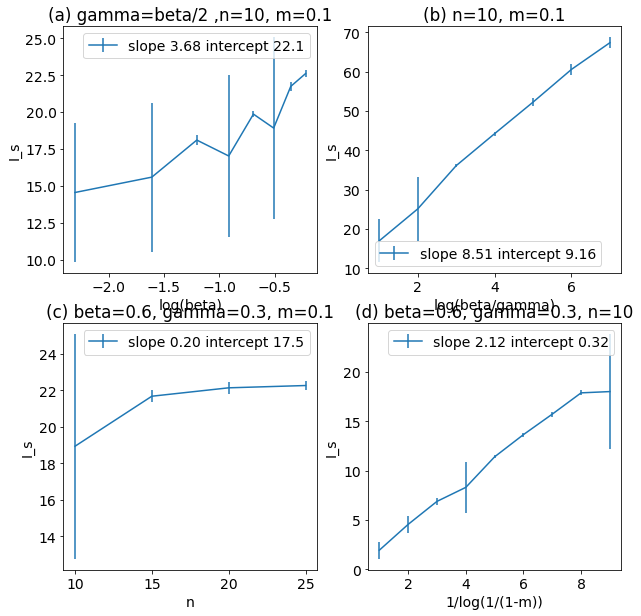

In [20]:
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
mean_results_gb_const_rrg=list(map(np.mean,results_gb_const_rrg))
std_results_gb_const_rrg=list(map(np.std,results_gb_const_rrg))
plt.errorbar(np.log(betas[:-1]),mean_results_gb_const_rrg[:-1],yerr=std_results_gb_const_rrg[:-1])
plt.ylabel("I_s")
plt.xlabel("log(beta)")
plt.title("(a) gamma=beta/2 ,n=10, m=0.1")
sl, inter = np.polyfit(np.log(betas[:-1]),mean_results_gb_const_rrg[:-1], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,2,2)
mean_results_gb_change_rrg=list(map(np.mean,results_gb_change_rrg))
std_results_gb_change_rrg=list(map(np.std,results_gb_change_rrg))
plt.errorbar(range(1,8),mean_results_gb_change_rrg[:-2], yerr= std_results_gb_change_rrg[:-2])
plt.title("(b) n=10, m=0.1")
plt.ylabel("I_s")
plt.xlabel("log(beta/gamma)")
sl, inter = np.polyfit(range(1,8),mean_results_gb_change_rrg[:-2], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,2,3)
mean_results_n_rrg=list(map(np.mean,results_n_rrg))
std_results_n_rrg=list(map(np.std,results_n_rrg))
plt.errorbar([10,15,20,25],mean_results_n_rrg,yerr=std_results_n_rrg)
plt.title("(c) beta=0.6, gamma=0.3, m=0.1")
plt.ylabel("I_s")
plt.xlabel("n")
sl, inter = np.polyfit([10,15,20,25],mean_results_n_rrg, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,2,4)
mean_results_max_inf_rrg=list(map(np.mean,results_max_inf_rrg))
std_results_max_inf_rrg=list(map(np.std,results_max_inf_rrg))
plt.errorbar(range(1,10),mean_results_max_inf_rrg,yerr=std_results_max_inf_rrg)
plt.title("(d) beta=0.6, gamma=0.3, n=10")
plt.ylabel("I_s")
plt.xlabel("1/log(1/(1-m))")
sl, inter = np.polyfit(range(1,10),mean_results_max_inf_rrg, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

From the slope of plot (b) we should have
$$\frac{1}{\log\left(\frac{1}{1-m}\right)} \approx 8.50$$

In [21]:
1/np.log(1/(1-0.1))

9.4912215810299

From the slope of plot (d) we should have
$$\log\left(c_g \frac{\beta}{\gamma}\right) \approx 1.62 \Rightarrow c_g \approx \frac{e^{1.62}}{2}\approx 2.5$$


In [22]:
np.exp(1.62)/2

2.526545158281934

From the intercept of plot (d) we should have
$$\frac{\log\left(c_g\right)}{\log\left(\frac{1}{1-m}\right)} \approx 9.2$$

In [23]:
np.log(np.exp(1.62)/2)/np.log(1/(1-0.1))

8.796965482307856

### Larger size

In [24]:
results_gb_change_rrg20 = run_one_seed_rrg(betas,betas/np.array(gb),[30], [0.1] ,"gb_change")

In [25]:
results_max_inf_rrg20 = run_one_seed_rrg([0.6],[0.3],[20], list(map(lambda x: 1-np.exp(-1/x), range(1,10))) ,"max_inf")

/home/doma945/p36/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/doma945/p36/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


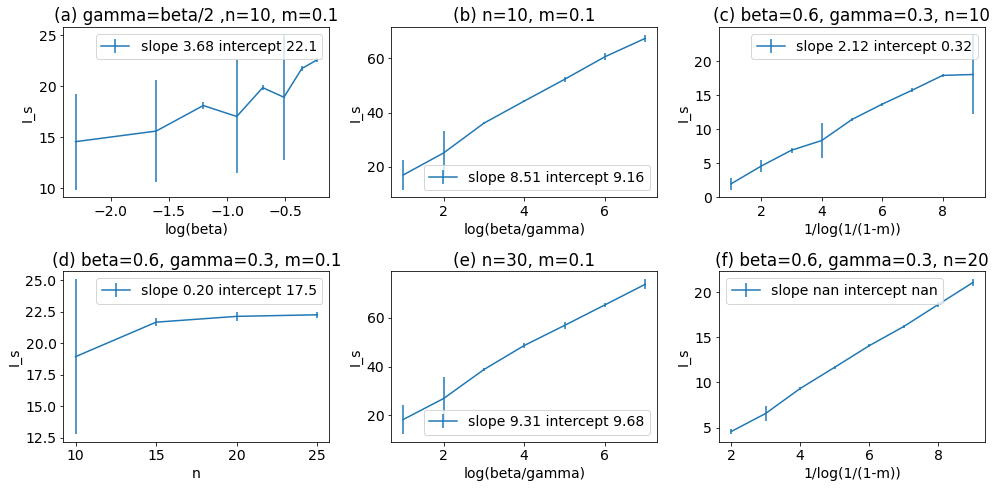

In [26]:
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(14,7))
plt.subplot(2,3,1)
mean_results_gb_const_rrg=list(map(np.mean,results_gb_const_rrg))
std_results_gb_const_rrg=list(map(np.std,results_gb_const_rrg))
plt.errorbar(np.log(betas[:-1]),mean_results_gb_const_rrg[:-1],yerr=std_results_gb_const_rrg[:-1])
plt.ylabel("I_s")
plt.xlabel("log(beta)")
plt.title("(a) gamma=beta/2 ,n=10, m=0.1")
sl, inter = np.polyfit(np.log(betas[:-1]),mean_results_gb_const_rrg[:-1], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,2)
mean_results_gb_change_rrg=list(map(np.mean,results_gb_change_rrg))
std_results_gb_change_rrg=list(map(np.std,results_gb_change_rrg))
plt.errorbar(range(1,8),mean_results_gb_change_rrg[:-2], yerr= std_results_gb_change_rrg[:-2])
plt.title("(b) n=10, m=0.1")
plt.ylabel("I_s")
plt.xlabel("log(beta/gamma)")
sl, inter = np.polyfit(range(1,8),mean_results_gb_change_rrg[:-2], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,3)
mean_results_max_inf_rrg=list(map(np.mean,results_max_inf_rrg))
std_results_max_inf_rrg=list(map(np.std,results_max_inf_rrg))
plt.errorbar(range(1,10),mean_results_max_inf_rrg,yerr=std_results_max_inf_rrg)
plt.title("(c) beta=0.6, gamma=0.3, n=10")
plt.ylabel("I_s")
plt.xlabel("1/log(1/(1-m))")
sl, inter = np.polyfit(range(1,10),mean_results_max_inf_rrg, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,4)
mean_results_n_rrg=list(map(np.mean,results_n_rrg))
std_results_n_rrg=list(map(np.std,results_n_rrg))
plt.errorbar([10,15,20,25],mean_results_n_rrg,yerr=std_results_n_rrg)
plt.title("(d) beta=0.6, gamma=0.3, m=0.1")
plt.ylabel("I_s")
plt.xlabel("n")
sl, inter = np.polyfit([10,15,20,25],mean_results_n_rrg, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])


plt.subplot(2,3,5)
mean_results_gb_change_rrg20=list(map(np.mean,results_gb_change_rrg20))
std_results_gb_change_rrg20=list(map(np.std,results_gb_change_rrg20))
plt.errorbar(range(1,8),mean_results_gb_change_rrg20[:-2], yerr= std_results_gb_change_rrg20[:-2])
plt.title("(e) n=30, m=0.1")
plt.ylabel("I_s")
plt.xlabel("log(beta/gamma)")
sl, inter = np.polyfit(range(1,8),mean_results_gb_change_rrg20[:-2], 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])

plt.subplot(2,3,6)
temp_results_max_inf_rrg20=results_max_inf_rrg20
temp_results_max_inf_rrg20=list(map(lambda y: list(filter(lambda x: x>2*np.sqrt(np.mean(y)), y)) ,temp_results_max_inf_rrg20))
mean_results_max_inf_rrg20=list(map(np.mean,temp_results_max_inf_rrg20))
std_results_max_inf_rrg20=list(map(np.std,temp_results_max_inf_rrg20))
plt.errorbar(range(1,10),mean_results_max_inf_rrg20,yerr=std_results_max_inf_rrg20)
plt.title("(f) beta=0.6, gamma=0.3, n=20")
plt.ylabel("I_s")
plt.xlabel("1/log(1/(1-m))")
sl, inter = np.polyfit(range(1,10),mean_results_max_inf_rrg20, 1)
plt.legend(["slope "+str(sl)[:4] +" intercept "+str(inter)[:4]])
plt.tight_layout()
plt.savefig("log/rgg.pdf")

In [27]:
np.exp(1.94)/2

3.479375485318636

## 2. Two infections (from two seeds) meeting vs one becoming extinct

We again have 4 parameters: $\beta, \gamma, n, m$. We suspect that for $\beta$ and $\gamma$ only their ratio matters but we do not assume this.

In [28]:
#betas = [0.9]
#gammas = [0.2]
#ns = [10]
#max_infs = [0.1]
#iterations = 1

betas = [0.3,0.75,0.75,0.6]
gammas = [0.2,0.5,0.2,0.5]
ns = [5,10,15,20,25,30,35,40]
max_infs = list(np.array(range(20))/100)
iterations = 10

results = []

for beta_i, beta in enumerate(betas):
    results.append([])
    gamma = gammas[beta_i]
    print("Beta ",beta, " Gamma ",gamma)
    for n_i, n in enumerate(ns):
        results[beta_i].append([])
        for max_inf_i, max_inf in enumerate(max_infs):
            results[beta_i][n_i].append(0)
            for it in range(iterations):
                graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
                args = dotdict({
                    "logfile": "data_awareness/example1_"+str(beta)+"_"+ str(gamma)+ "_" +str(n)+"_"+ str(max_inf)+ "_" +str(it) +".csv",
                    "plot": False,
                    "max_iteration": 1000,
                    "beta": beta,
                    "beta_super":0.0,
                    "sigma": 0.5,
                    "gamma": gamma,
                    "xi": 1,
                    "p_teleport":0.0,
                    "MAX_E_TIME":10,
                    "MAX_I_TIME":10,
                    "infected_agents": [3,n*n-4],
                    "super_infected_agents": [],
                    "p_super": 0.0,
                    "awM": max_inf,
                    "awR": -1,
                })
                args["I_time"]=int(1/args["gamma"])

                country = Agent_Country(args, graph)
                #country.log_json()
                for i in range(args["max_iteration"]):
                    if country.check_stop2():
                        #print("Infection extinction at iteration: {}".format(i))
                        break
                    merged = country.step()
                    #country.log_json()

                    if (merged):
                        #print("Infections merged at iteration: {}".format(i))
                        results[beta_i][n_i][max_inf_i]+=1
                        break


Beta  0.3  Gamma  0.2
Beta  0.75  Gamma  0.5
Beta  0.75  Gamma  0.2
Beta  0.6  Gamma  0.5


/tmp/ipykernel_9386/482706764.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0]+ns)
/tmp/ipykernel_9386/482706764.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(max_infs[::3])


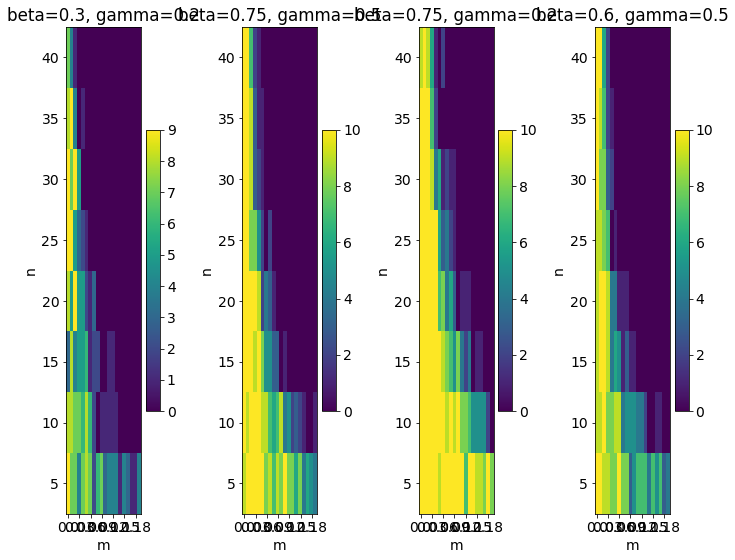

In [29]:
betas = [0.3,0.75,0.75,0.6]
gammas = [0.2,0.5,0.2,0.5]
ns = [5,10,15,20,25,30,35,40]
max_infs = list(np.array(range(20))/100)
iterations = 10

plt.figure(figsize=(10,8))
for beta_i, beta in enumerate(betas):
    gamma = gammas[beta_i]
    ax=plt.subplot(1,4,beta_i+1)
    plt.imshow(np.array(results[beta_i]), aspect='auto', origin="lower")
    plt.ylabel("n")
    ax.set_yticklabels([0]+ns)
    ax.set_xticklabels(max_infs[::3])
    ax.set_xticks(range(len(max_infs))[::3])
    plt.xlabel("m")
    plt.title("beta="+str(beta) +", gamma="+str(gamma))
    plt.colorbar()
    
plt.tight_layout()
plt.savefig("log/compete_m.pdf")

### Let us look at this as a function of I_avg, not max_inf

In [30]:
#betas = [0.9]
#gammas = [0.2]
#ns = [10]
#max_infs = [0.1]
#iterations = 1

betas = [0.3,0.75,0.75,0.6]
gammas = [0.2,0.5,0.2,0.5]
ns = [5,10,15,20,25,30,35,40]
iterations = 10

results2 = []

for beta_i, beta in enumerate(betas):
    results2.append([])
    gamma = gammas[beta_i]
    print("Beta ",beta, " Gamma ",gamma)
    for n_i, n in enumerate(ns):
        results2[beta_i].append([])

        max_infs = list(map(lambda x: 1-(2.66*beta/gamma)**(-1/x), np.array(range(1,20))*4))
        for max_inf_i, max_inf in enumerate(max_infs):
            results2[beta_i][n_i].append(0)
            for it in range(iterations):
                graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
                args = dotdict({
                    "logfile": "data_awareness/example3_"+str(beta)+"_"+ str(gamma)+ "_" +str(n)+"_"+ str(max_inf)+ "_" +str(it) +".csv",
                    "plot": False,
                    "max_iteration": 1000,
                    "beta": beta,
                    "beta_super":0.0,
                    "sigma": 0.5,
                    "gamma": gamma,
                    "xi": 1,
                    "p_teleport":0.0,
                    "MAX_E_TIME":10,
                    "MAX_I_TIME":10,
                    "infected_agents": [3,n*n-4],
                    "super_infected_agents": [],
                    "p_super": 0.0,
                    "awM": max_inf,
                    "awR": -1,
                })
                args["I_time"]=int(1/args["gamma"])

                country = Agent_Country(args, graph)
                #country.log_json()
                for i in range(args["max_iteration"]):
                    if country.check_stop2():
                        #print("Infection extinction at iteration: {}".format(i))
                        break
                    merged = country.step()
                    #country.log_json()

                    if (merged):
                        #print("Infections merged at iteration: {}".format(i))
                        results2[beta_i][n_i][max_inf_i]+=1
                        break

Beta  0.3  Gamma  0.2
Beta  0.75  Gamma  0.5
Beta  0.75  Gamma  0.2
Beta  0.6  Gamma  0.5


/tmp/ipykernel_9386/1938100567.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0]+ns[::2])
/tmp/ipykernel_9386/1938100567.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(np.array(range(1,20))*4)[::4])


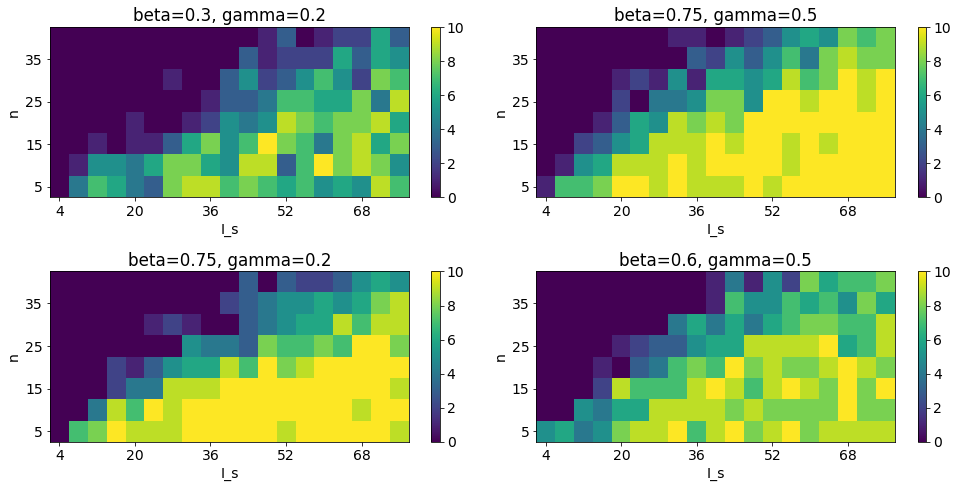

In [31]:
betas = [0.3,0.75,0.75,0.6]
gammas = [0.2,0.5,0.2,0.5]
ns = [5,10,15,20,25,30,35,40]
max_infs = list(np.array(range(20))/100)
iterations = 10

plt.figure(figsize=(14,7))
for beta_i, beta in enumerate(betas):
    gamma = gammas[beta_i]
    ax=plt.subplot(2,2,beta_i+1)
    plt.imshow(np.array(results2[beta_i]), aspect='auto', origin="lower")
    plt.ylabel("n")
    ax.set_yticklabels([0]+ns[::2])
    ax.set_xticklabels(list(np.array(range(1,20))*4)[::4])
    ax.set_xticks(range(len(max_infs))[::4])
    plt.xlabel("I_s")
    plt.title("beta="+str(beta) +", gamma="+str(gamma))
    plt.colorbar()
    
plt.tight_layout()
plt.savefig("log/compete_I.pdf")

## R-dependence

In [32]:
def run_one_seed_r(betas,gammas,ns,max_infs,rs,name):
    results = []
    iterations=10

    for beta_i, beta in enumerate(betas):
        for n_i, n in enumerate(ns):
            for max_inf_i, max_inf in enumerate(max_infs):
                for r_i, r in enumerate(rs):
                    results.append([])
                    for it in range(iterations):
                        temp_results =[]
                        graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
                        args = dotdict({
                            "logfile": "data_awareness/example2" +name +"_"+str(beta)+"_"+ str(gammas[beta_i])+ "_" +str(n)+"_"+ str(max_inf)+ "_" +str(it) +".csv",
                            "plot": False,
                            "max_iteration": 1000,
                            "beta": beta,
                            "beta_super":0.0,
                            "sigma": 0.5,
                            "gamma": gammas[beta_i],
                            "xi": 1,
                            "p_teleport":0.0,
                            "MAX_E_TIME":10,
                            "MAX_I_TIME":10,
                            "infected_agents": [n//2+(n//2)*n],
                            "super_infected_agents": [],
                            "p_super": 0.0,
                            "awM": max_inf,
                            "awR": r,
                        })
                        args["I_time"]=int(1/args["gamma"])

                        country = Agent_Country(args, graph)
                        #country.log_json()
                        for i in range(args["max_iteration"]):
                            temp_results.append(np.sum(country.states==2))
                            if country.check_stop():
                                #print("Infection extinction at iteration: {}".format(i))
                                break
                            country.step()
                            #country.log_json()
                        results[-1].append(np.mean(temp_results[len(temp_results)//2:]))
    return results

In [33]:
rs = [0,0.5,1,1.5,2,2.5]
results_r_grid=[]
for r in rs:
    print(r)
    results_r_grid.append(run_one_seed_r([0.6],[0.3],[10,15,20,25,30], [0.1], [r] ,"n"))

0
0.5
1
1.5
2
2.5


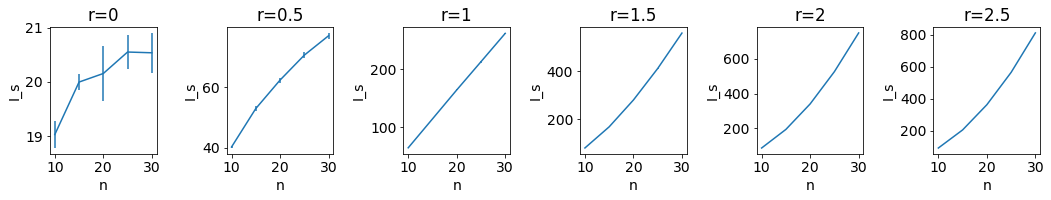

In [34]:
plt.figure(figsize=(15,3))
for r_i, r in enumerate(rs):
    plt.subplot(1,6,r_i+1)
    temp_results_r_grid=results_r_grid[r_i]
    temp_results_r_grid=list(map(lambda y: list(filter(lambda x: x>10, y)) ,temp_results_r_grid))
    mean_results_r_grid=list(map(np.mean,temp_results_r_grid))
    std_results_r_grid=list(map(np.std,temp_results_r_grid))
    plt.errorbar([10,15,20,25,30],mean_results_r_grid,yerr=std_results_r_grid)
    plt.title("r="+str(r))
    plt.ylabel("I_s")
    plt.xlabel("n")
plt.tight_layout()

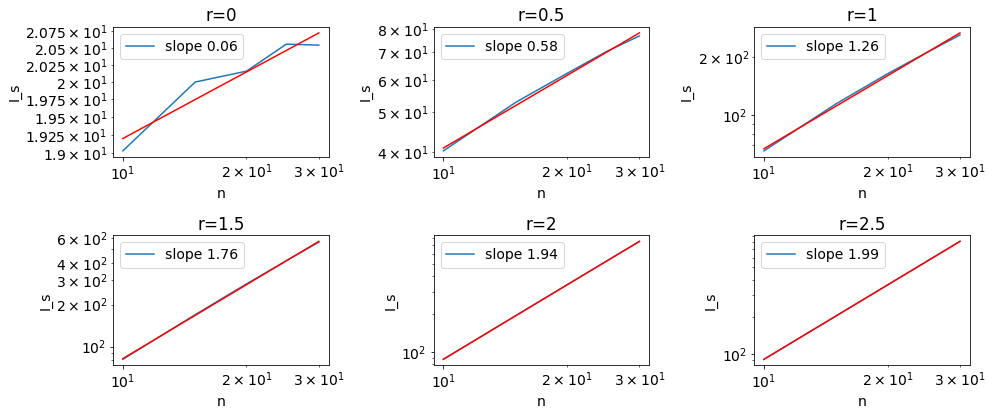

In [35]:
Ns=[10,15,20,25,30]
plt.figure(figsize=(14,6))
for r_i, r in enumerate(rs):
    plt.subplot(2,3,r_i+1)
    temp_results_r_grid=results_r_grid[r_i]
    temp_results_r_grid=list(map(lambda y: list(filter(lambda x: x>10, y)) ,temp_results_r_grid))
    mean_results_r_grid=list(map(np.mean,temp_results_r_grid))
    plt.plot(Ns,mean_results_r_grid)
    plt.title("r="+str(r))
    plt.ylabel("I_s")
    plt.xlabel("n")
    sl, inter = np.polyfit(np.log(Ns),np.log(mean_results_r_grid), 1)
    plt.plot(Ns,list(map(lambda X: np.exp(inter)*X**sl,Ns)),"r")

    plt.legend(["slope "+str(sl)[:4]])
    plt.xscale("log")
    plt.yscale("log")

    
plt.tight_layout()
plt.savefig("log/r-dep_grid_0603.pdf")

### Different beta and gamma

In [36]:
rs = [0,0.5,1,1.5,2,2.5]
results_r_grid2=[]
for r in rs:
    print(r)
    results_r_grid2.append(run_one_seed_r([0.75],[0.2],[10,15,20,25,30], [0.1], [r] ,"n"))

0
0.5
1
1.5
2
2.5


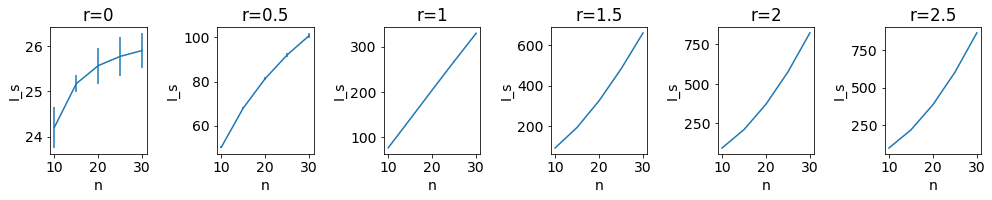

In [37]:
plt.figure(figsize=(14,3))
for r_i, r in enumerate(rs):
    plt.subplot(1,6,r_i+1)
    temp_results_r_grid=results_r_grid2[r_i]
    temp_results_r_grid=list(map(lambda y: list(filter(lambda x: x>10, y)) ,temp_results_r_grid))
    mean_results_r_grid=list(map(np.mean,temp_results_r_grid))
    std_results_r_grid=list(map(np.std,temp_results_r_grid))
    plt.errorbar([10,15,20,25,30],mean_results_r_grid,yerr=std_results_r_grid)
    plt.title("r="+str(r))
    plt.ylabel("I_s")
    plt.xlabel("n")
plt.tight_layout()

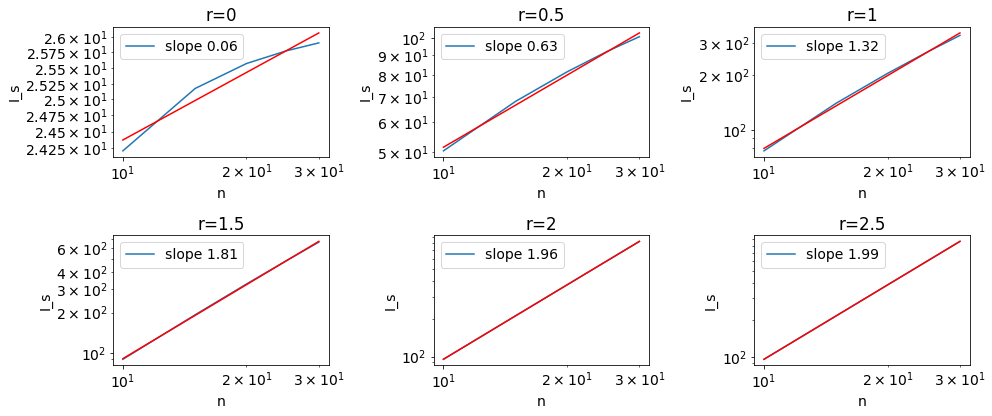

In [38]:
Ns=[10,15,20,25,30]
plt.figure(figsize=(14,6))
for r_i, r in enumerate(rs):
    plt.subplot(2,3,r_i+1)
    temp_results_r_grid=results_r_grid2[r_i]
    temp_results_r_grid=list(map(lambda y: list(filter(lambda x: x>10, y)) ,temp_results_r_grid))
    mean_results_r_grid=list(map(np.mean,temp_results_r_grid))
    plt.plot(Ns,mean_results_r_grid)
    plt.title("r="+str(r))
    plt.ylabel("I_s")
    plt.xlabel("n")
    sl, inter = np.polyfit(np.log(Ns),np.log(mean_results_r_grid), 1)
    plt.plot(Ns,list(map(lambda X: np.exp(inter)*X**sl,Ns)),"r")

    plt.legend(["slope "+str(sl)[:4]])
    plt.xscale("log")
    plt.yscale("log")

    
plt.tight_layout()
plt.savefig("log/r-dep_grid_07502.pdf")